<a href="https://colab.research.google.com/github/krzysztof-kar/ML2025/blob/main/Lab06_tree-methods_prdom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework Assignment: Understanding Splitting Criteria in CART for Regression**
---------------------

In this assignment, you will explore three common formulations of the splitting criterion used in **CART (Classification and Regression Trees)** for **regression problems**:

1. **Local RSS Minimization**  
2. **RSS Gain Maximization**  
3. **Total RSS Minimization**

You will investigate whether any of these criteria are equivalent, and you will design an experiment to determine which criterion is actually employed in a standard implementation such as **scikit-learn’s DecisionTreeRegressor**.



## **The Problem**

Many treatments of CART for regression describe the split selection process in different ways. Below are three frequently cited formulations. Suppose we have a dataset with features $X$ and target $y$, and we seek to choose a feature $X_j$ and a threshold $t$ to split the data into two regions $R_1(X_j, t)$ and $R_2(X_j, t)$. Denote by $\bar{y}_{R_m}$ the mean of targets within region $R_m$.

1. **Local RSS Minimization**  
   We select the feature and threshold that minimize the **sum of squared errors** in the two resulting child nodes:
   $$
   (X_j^*, t^*) = \arg\min_{X_j, t} \sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2.
   $$

2. **RSS Gain Maximization**  

   It is also a local method, looking only at a parent and two child nodes.

   We select the feature and threshold that maximize the **reduction** in RSS, computed by subtracting the RSS of the two child nodes from the RSS in the parent node:
   $$
   (X_j^*, t^*) = \arg\max_{X_j, t} \Bigl\{
   \underbrace{\sum_{i : x_i \in \text{Parent}} (y_i - \bar{y})^2}_{\text{Parent RSS}}
   \;-\;
   \underbrace{\sum_{m=1}^{2} \sum_{i : x_i \in R_m(X_j, t)} (y_i - \bar{y}_{R_m})^2}_{\text{Children RSS}}
   \Bigr\}.
   $$

3. **Total RSS Minimization**  
   For a dataset $\{(x_i, y_i)\}_{i=1}^N$ with features $X$ and target $y$, let $T$ be the current tree.

   For any split on feature $X_j$ at threshold $t$, define $T(X_j, t)$ as the new tree obtained by splitting one leaf of $T$ into two leaves $R_1(X_j, t)$ and $R_2(X_j, t)$.
   
   Let $\mathrm{Leaves}(T(X_j, t))$ be the set of all leaf indices in this new tree. For each leaf $m \in \mathrm{Leaves}(T(X_j, t))$, define:
   $$
   R_m = \{\, i \,\mid\, x_i \text{ ends in leaf } m\}.
   $$

   $R_m$ set collects all data indices $i$ whose feature vector $x_i$ is classified into the leaf node $m$ when passed through the tree $T(X_j,t)$. In other words, each leaf node $m$ in $T(X_j, t)$ corresponds to a unique path of splits, and any data point $x_i$ that follows that path is assigned to the leaf $m$; hence, it belongs to $R_m$.

   $R_m$ sets for all leafs $m \in \mathrm{Leaves}(T(X_j, t))$ define a partition of all indices.

   Then the objective of **minimizing total Residual Sum of Squares (total RSS)** is stated as:
   $$
   (X_j^*, t^*) = \arg\min_{(X_j, t)} \sum_{m \in \mathrm{Leaves}(T(X_j, t))}
   \sum_{i \in R_m} \Bigl(y_i - \overline{y}_{R_m}\Bigr)^2,
   $$
   where
   $$
   \overline{y}_{R_m} = \frac{1}{\lvert R_m \rvert}
   \sum_{i \in R_m} y_i
   $$
   is the mean response in leaf $m$.


## **Research Questions**

1. **Equivalence Analysis**  
   Determine whether the above formulations are equivalent or if they can yield different split choices. Specifically:
   - Are *local RSS minimization* and *RSS gain maximization* equivalent?
   - Does *total RSS minimization* coincide with either of these two, or is it distinct?
   
2. **Empirical Experiment**  
   Design and conduct a Python experiment to determine which of these formulations is implemented in `scikit-learn` in `DecisionTreeRegressor`. Present numerical results and plots to support your conclusion.


## **Tasks & Deliverables**

1. **Formulation Analysis**  
   - Compare *local RSS minimization*, *RSS gain maximization*, and *total RSS minimization*.
   - If you find that any pair of formulations is equivalent, provide a concise proof.  
   - If you find that they differ, construct a counterexample.

2. **Empirical Verification**  
   - Create a small artificial dataset and train a `DecisionTreeRegressor` from `scikit-learn`.
   - The dataset must be designed in a way that uniquely identifies the formulation used. Provide a short code snippet and a plot or table to support your conclusion.

3. **Report**  
   - Summarize your theoretical insights and empirical findings in a **Colab notebook**.
   - Include the relevant proofs, code, discussion, and conclusions.
   - Place the notebook in your **GitHub repository** for this course, add a link to it in your README.md and add an **“Open in Colab”** badge in the notebook so it can be launched directly.



TypeError: Axes.scatter() got multiple values for argument 's'

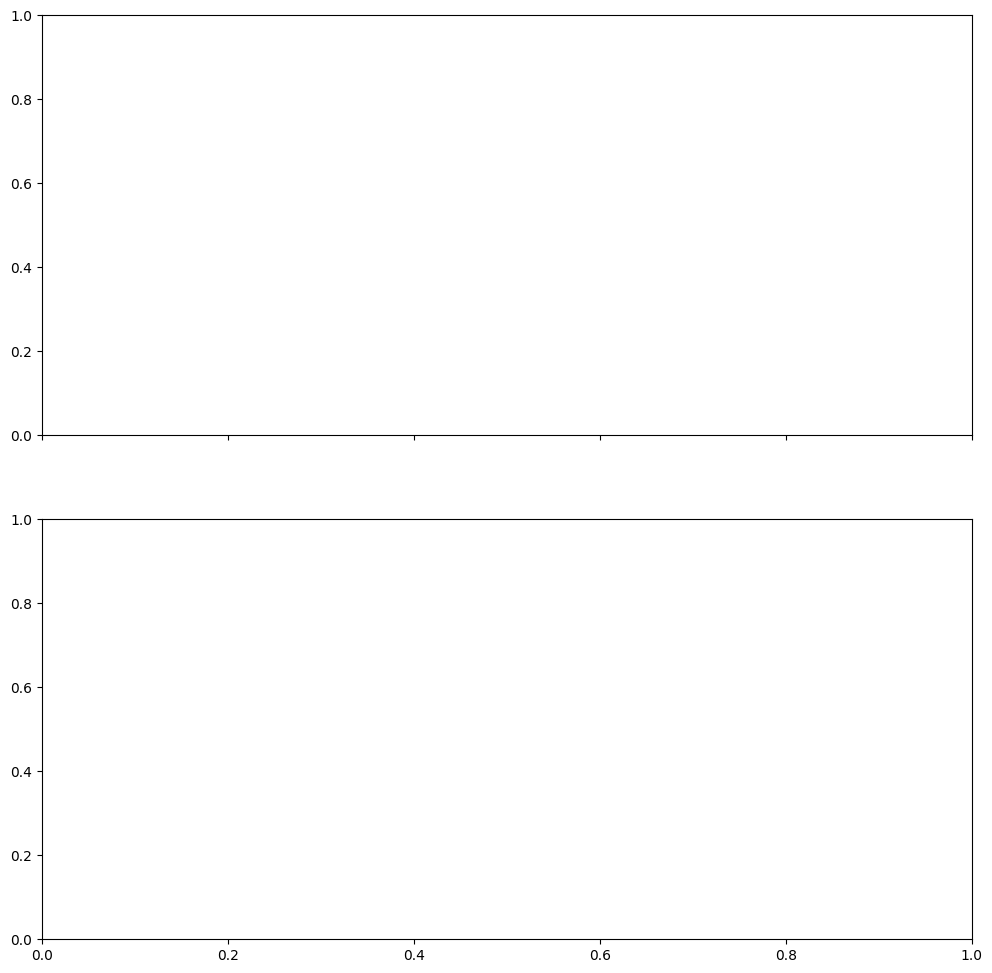

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate synthetic data
np.random.seed(42)
rs = np.random.RandomState(1234)


n_samples = 100
# X is the input features by row.
Y = np.zeros(n_samples)
Y[:n_samples//2] = np.random.normal(2, 1, n_samples//2)
Y[n_samples//2:] = np.random.normal(7, 1, n_samples//2)
Y = np.sort(Y)

X1 = np.sort((np.random.rand(100) * 10))

x1,y1 = np.meshgrid(X1,Y)

y = np.log(x1+y1) + np.random.normal(0, 0.3)  # Noisy sine wave

# Step 2: Analyze possible splits and compute SSR
def compute_ssr(y):
    mean_y = np.mean(y)
    return np.sum((y - mean_y) ** 2)

best_ssr = float('inf')
best_split = None
ssr_list = []

# Consider splits between adjacent sorted X values
for i in range(1, len(X)):
    threshold = (X[i - 1] + X[i]) / 2

    # Split data using boolean masks
    left_mask = X < threshold
    right_mask = X >= threshold

    # Calculate SSR for each region
    ssr_left = compute_ssr(y[left_mask])
    ssr_right = compute_ssr(y[right_mask])
    total_ssr = ssr_left + ssr_right

    ssr_list.append((threshold, total_ssr))

    # Keep track of the best split
    if total_ssr < best_ssr:
        best_ssr = total_ssr
        best_split = threshold

# Visualize the data, splits, and the best split along with SSR values
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)  # Two vertically aligned subplots

# First subplot: Original data with split lines
axes[0].scatter(x1,y1, y, color='blue', label='Data Points', s=30)

for threshold, ssr in ssr_list:
    axes[0].axvline(x=threshold, color='gray', linestyle='--', alpha=0.2)

axes[0].axvline(x=best_split, color='red', linestyle='-', linewidth=2, label=f'Best Split at x={best_split:.2f}')
axes[0].set_title('Analyzing and Selecting Best Split Based on SSR')
axes[0].set_ylabel('Target y')
axes[0].legend()

# Second subplot: SSR values for each split
thresholds, ssrs = zip(*ssr_list)
axes[1].plot(thresholds, ssrs, marker='o', color='purple')
axes[1].axvline(x=best_split, color='red', linestyle='--', label=f'Best Split at x={best_split:.2f}')
axes[1].set_title('Sum of Squared Residuals (SSR) for Each Possible Split (TOTAL SSR)')
axes[1].set_xlabel('Threshold Value')
axes[1].set_ylabel('SSR')
axes[1].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


print(f"Best split at x = {best_split:.2f} with TOTAL SSR = {best_ssr:.2f}")

In [ ]:

from mpl_toolkits.mplot3d import Axes3D


rs = np.random.RandomState(1234)

# Generate some fake data.
n_samples = 200
# X is the input features by row.
Y = np.zeros((200,3))
Y[:n_samples/2] = rs.multivariate_normal( np.ones(3), np.eye(3), size=n_samples/2)
Y[n_samples/2:] = rs.multivariate_normal(-np.ones(3), np.eye(3), size=n_samples/2)
# Y is the class labels for each row of X.
Y = np.zeros(n_samples); Y[n_samples/2:] = 1



# The equation of the separating plane is given by all x in R^3 such that:
# np.dot(svc.coef_[0], x) + b = 0. We should solve for the last coordinate
# to plot the plane in terms of x and y.

z = lambda x,y: (-svc.intercept_[0]-svc.coef_[0][0]*x-svc.coef_[0][1]*y) / svc.coef_[0][2]

tmp = np.linspace(-2,2,51)
x,y = np.meshgrid(tmp,tmp)

# Plot stuff.
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z(x,y))
ax.plot3D(X[Y==0,0], X[Y==0,1], X[Y==0,2],'ob')
ax.plot3D(X[Y==1,0], X[Y==1,1], X[Y==1,2],'sr')
plt.show()